In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from torch.autograd import Variable

import ale_py

In [2]:
# Hyperparameters
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 100000
TARGET_UPDATE_FREQ = 1000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 10000

# Environment setup
env = gym.make("ALE/Pong-v5", frameskip=4)
n_actions = env.action_space.n
input_shape = (4, 84, 84)  # 4 stacked frames

def preprocess_frame(frame):
    frame = frame.mean(axis=-1)  # Grayscale
    frame = frame[34:194]  # Crop
    frame = frame[::2, ::2]  # Downsample
    return frame.astype(np.float32) / 255.0

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape
        #print(f"input shape is : {input_shape}")
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        
        o = self.conv(torch.zeros(1, *shape))
        #print(f"Convolution output shape during initialization: {o.shape}")
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        conv_out_flattened = conv_out.view(conv_out.size()[0], -1) 
        #print(f"Convolutional output shape and after conv_out.view(conv_out.size()[0], -1)  : {conv_out.shape}, {conv_out_flattened.shape}")
        return self.fc(conv_out_flattened)##

def epsilon_greedy_action(state, q_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
    with torch.no_grad():
        return q_net(state).argmax(dim=1).item()


q_net = DQN(input_shape, n_actions).cuda()
target_net = DQN(input_shape, n_actions).cuda()
target_net.load_state_dict(q_net.state_dict())
optimizer = optim.Adam(q_net.parameters(), lr=LR)
memory = ReplayMemory(REPLAY_MEMORY_SIZE)

state, _ = env.reset()  
state = preprocess_frame(state)
state = np.stack([state] * 4, axis=0) 

epsilon = EPSILON_START
total_steps = 0

reward_history = []  
loss_history = []  

for episode in range(1, 1001):
    state, _ = env.reset()  
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)  
    
    total_reward = 0
    episode_losses = []

    while True:
        total_steps += 1
        epsilon = max(EPSILON_END, EPSILON_START - total_steps / EPSILON_DECAY)
        action = epsilon_greedy_action(state, q_net, epsilon, n_actions)
        next_state, reward, done, _, _ = env.step(action)
        next_frame = preprocess_frame(next_state)
        next_state = np.append(state[1:], np.expand_dims(next_frame, axis=0), axis=0)

        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        if len(memory) >= BATCH_SIZE:
            batch = memory.sample(BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.tensor(np.array(states), dtype=torch.float32).cuda()
            actions = torch.tensor(actions, dtype=torch.long).cuda()
            rewards = torch.tensor(rewards, dtype=torch.float32).cuda()
            next_states = torch.tensor(np.array(next_states), dtype=torch.float32).cuda()
            dones = torch.tensor(dones, dtype=torch.float32).cuda()

            q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            next_q_values = target_net(next_states).max(1)[0]
            expected_q_values = rewards + GAMMA * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, expected_q_values)
            episode_losses.append(loss.item())  # Record loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if total_steps % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(q_net.state_dict())

        if done:
            reward_history.append(total_reward)  
            loss_history.append(np.mean(episode_losses))
            print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {epsilon:.2f}, Loss: {np.mean(episode_losses):.4f}")
            break

    if episode % 10 == 0:
        avg_reward = np.mean(reward_history[-100:]) if len(reward_history) >= 100 else np.mean(reward_history)
        print(f"Last 100 Avg Reward: {avg_reward:.2f}, Total Steps: {total_steps}, Avg Loss: {np.mean(loss_history[-10:]):.4f}")


Episode: 1, Reward: -21.0, Epsilon: 0.92, Loss: 0.0201
Episode: 2, Reward: -21.0, Epsilon: 0.84, Loss: 0.0226
Episode: 3, Reward: -20.0, Epsilon: 0.75, Loss: 0.0173
Episode: 4, Reward: -21.0, Epsilon: 0.66, Loss: 0.0145
Episode: 5, Reward: -21.0, Epsilon: 0.57, Loss: 0.0183
Episode: 6, Reward: -21.0, Epsilon: 0.49, Loss: 0.0175
Episode: 7, Reward: -21.0, Epsilon: 0.41, Loss: 0.0186
Episode: 8, Reward: -19.0, Epsilon: 0.30, Loss: 0.0169
Episode: 9, Reward: -20.0, Epsilon: 0.22, Loss: 0.0103
Episode: 10, Reward: -21.0, Epsilon: 0.14, Loss: 0.0086
Last 100 Avg Reward: -20.60, Total Steps: 8630, Avg Loss: 0.0165
Episode: 11, Reward: -21.0, Epsilon: 0.10, Loss: 0.0076
Episode: 12, Reward: -20.0, Epsilon: 0.10, Loss: 0.0082
Episode: 13, Reward: -21.0, Epsilon: 0.10, Loss: 0.0082
Episode: 14, Reward: -21.0, Epsilon: 0.10, Loss: 0.0081
Episode: 15, Reward: -21.0, Epsilon: 0.10, Loss: 0.0067
Episode: 16, Reward: -21.0, Epsilon: 0.10, Loss: 0.0073
Episode: 17, Reward: -21.0, Epsilon: 0.10, Loss:

KeyboardInterrupt: 

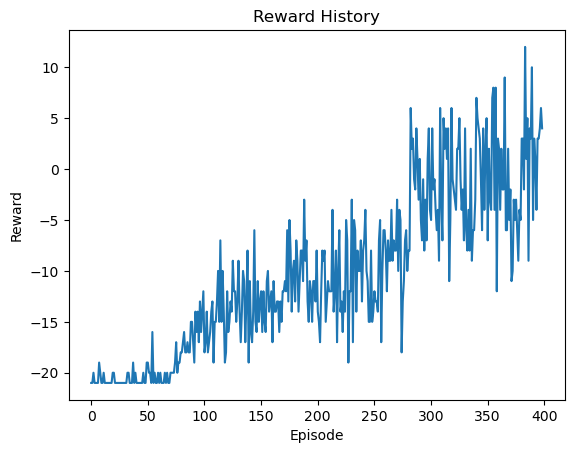

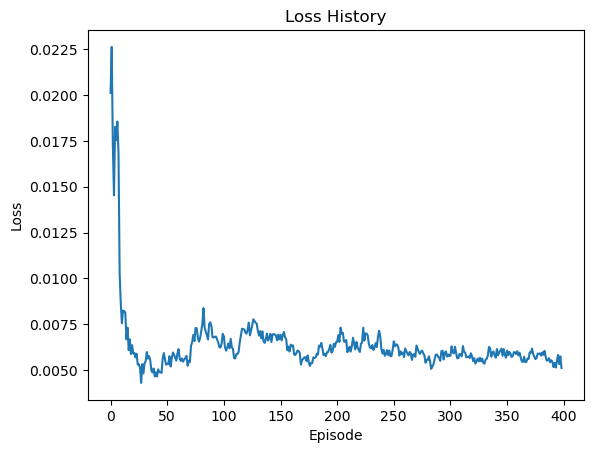

In [6]:
# Save the trained model
torch.save(q_net.state_dict(), "dqn_pong_model.pth")

# Plot reward graph
plt.figure()
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward History")
plt.savefig("reward_history.png")
plt.show()

# Plot loss graph
plt.figure()
plt.plot(loss_history)
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Loss History")
plt.savefig("loss_history.png")
plt.show()

Episode 1, Total Reward (Perturbed): 8.0, Average Loss: 3.2490
Episode 2, Total Reward (Perturbed): 8.0, Average Loss: 3.4145
Episode 3, Total Reward (Perturbed): 8.0, Average Loss: 3.4711
Episode 4, Total Reward (Perturbed): 5.0, Average Loss: 3.3179
Episode 5, Total Reward (Perturbed): 4.0, Average Loss: 3.2016
Episode 6, Total Reward (Perturbed): 4.0, Average Loss: 3.2961
Episode 7, Total Reward (Perturbed): 10.0, Average Loss: 3.2394
Episode 8, Total Reward (Perturbed): 7.0, Average Loss: 3.2059
Episode 9, Total Reward (Perturbed): 5.0, Average Loss: 3.2240
Episode 10, Total Reward (Perturbed): 3.0, Average Loss: 3.1816
Episode 11, Total Reward (Perturbed): 5.0, Average Loss: 3.1909
Episode 12, Total Reward (Perturbed): -11.0, Average Loss: 3.1063
Episode 13, Total Reward (Perturbed): 9.0, Average Loss: 3.3278
Episode 14, Total Reward (Perturbed): 10.0, Average Loss: 3.2363
Episode 15, Total Reward (Perturbed): 4.0, Average Loss: 3.2739
Episode 16, Total Reward (Perturbed): 12.0, A

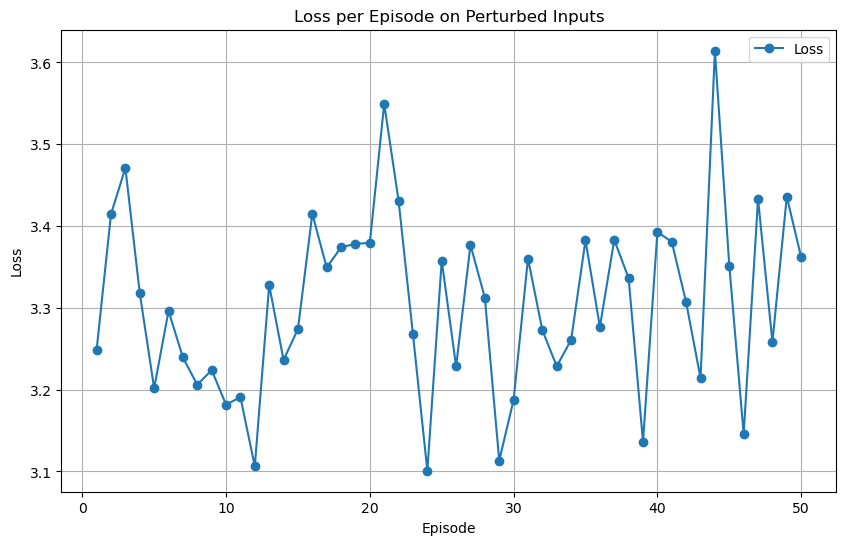

In [10]:
def preprocess_frame(frame):
    frame = frame.mean(axis=-1)  # Grayscale
    frame = frame[34:194]  # Crop
    frame = frame[::2, ::2]  # Downsample
    return frame.astype(np.float32) / 255.0

def pgd_pong(model, X, y, params={}):
    epsilon = params.get('epsilon', 0.01)
    niters = params.get('niters', 4)
    img_min = params.get('img_min', 0.0)
    img_max = params.get('img_max', 1.0)
    loss_func = params.get('loss_func', nn.CrossEntropyLoss())
    step_size = epsilon / niters

    X_adv = X.clone()
    X_adv = Variable(X_adv.data, requires_grad=True)
    y = Variable(torch.tensor(y, dtype=torch.float32)).cuda()

    for _ in range(niters):
        logits = model.forward(X_adv)
        loss = loss_func(logits, y)

        model.zero_grad()
        loss.backward()

        eta = step_size * X_adv.grad.data.sign()
        X_adv = Variable(X_adv.data + eta, requires_grad=True)

        eta = torch.clamp(X_adv.data - X.data, -epsilon, epsilon)
        X_adv.data = torch.clamp(X.data + eta, img_min, img_max)

    return X_adv.data

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape
        #print(f"input shape is : {input_shape}")
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        
        o = self.conv(torch.zeros(1, *shape))
        #print(f"Convolution output shape during initialization: {o.shape}")
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        conv_out_flattened = conv_out.view(conv_out.size()[0], -1) 
        #print(f"Convolutional output shape and after conv_out.view(conv_out.size()[0], -1)  : {conv_out.shape}, {conv_out_flattened.shape}")
        return self.fc(conv_out_flattened)##

def epsilon_greedy_action(state, q_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
    with torch.no_grad():
        return q_net(state).argmax(dim=1).item()

vanilla_dqn = DQN(input_shape, n_actions).cuda()
vanilla_dqn.load_state_dict(torch.load("dqn_pong_model.pth"))
vanilla_dqn.eval()

num_test_episodes = 50
reward_history = []  
loss_history = []  

for episode in range(num_test_episodes):
    state, _ = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0) 
    total_reward = 0
    episode_losses = []

    while True:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
        action = vanilla_dqn(state_tensor).argmax(dim=1).item()
        perturbed_state_tensor = pgd_pong(vanilla_dqn, state_tensor, action, pgd_params)

        perturbed_state = perturbed_state_tensor.cpu().numpy()[0]
        next_state, reward, done, _, _ = env.step(action)

        next_frame = preprocess_frame(next_state)
        next_state = np.append(state[1:], np.expand_dims(next_frame, 0), axis=0)
        state = next_state
        total_reward += reward

        target_q = torch.tensor(reward, dtype=torch.float32).cuda() 
        predicted_q = vanilla_dqn(state_tensor).max(1)[0]
        loss = nn.MSELoss()(predicted_q, target_q)
        episode_losses.append(loss.item())

        if done:
            reward_history.append(total_reward)
            loss_history.append(np.mean(episode_losses)) 
            print(f"Episode {episode + 1}, Total Reward (Perturbed): {total_reward}, Average Loss: {np.mean(episode_losses):.4f}")
            break

average_reward_perturbed = np.mean(reward_history)
print(f"Average Reward on Perturbed Inputs: {average_reward_perturbed:.2f}")

env.close()

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_test_episodes + 1), loss_history, marker='o', label="Loss")
plt.title("Loss per Episode on Perturbed Inputs")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()



In [6]:
# Hyperparameters
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 32
REPLAY_MEMORY_SIZE = 100000
TARGET_UPDATE_FREQ = 1000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 10000

# Environment setup
env = gym.make("ALE/Pong-v5", frameskip=4)
n_actions = env.action_space.n
input_shape = (4, 84, 84)  # 4 stacked frames

def preprocess_frame(frame):
    frame = frame.mean(axis=-1)  # Grayscale
    frame = frame[34:194]  # Crop
    frame = frame[::2, ::2]  # Downsample
    return frame.astype(np.float32) / 255.0

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape
        #print(f"input shape is : {input_shape}")
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        
        o = self.conv(torch.zeros(1, *shape))
        #print(f"Convolution output shape during initialization: {o.shape}")
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        conv_out_flattened = conv_out.view(conv_out.size()[0], -1) 
        #print(f"Convolutional output shape and after conv_out.view(conv_out.size()[0], -1)  : {conv_out.shape}, {conv_out_flattened.shape}")
        return self.fc(conv_out_flattened)##

def epsilon_greedy_action(state, q_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).cuda()
    with torch.no_grad():
        return q_net(state).argmax(dim=1).item()

vanilla_dqn = DQN(input_shape, n_actions).cuda()
vanilla_dqn.load_state_dict(torch.load("dqn_pong_model.pth"))
vanilla_dqn.eval()

num_test_episodes = 50
loss_history = []  
total_rewards = []

for episode in range(1, num_test_episodes + 1):
    state, _ = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)
    episode_reward = 0

    while True:
        action = epsilon_greedy_action(state, vanilla_dqn, epsilon=0.0, n_actions=n_actions)  # Always choose the best action
        next_state, reward, done, _, _ = env.step(action)
        next_frame = preprocess_frame(next_state)
        state = np.append(state[1:], np.expand_dims(next_frame, axis=0), axis=0)

        episode_reward += reward

        if done:
            print(f"Test Episode {episode}: Reward = {episode_reward}")
            total_rewards.append(episode_reward)
            break

env.close()
avg_reward = np.mean(total_rewards)
print(f"Average Test Reward over {n_episodes} episodes: {avg_reward:.2f}")


Test Episode 1: Reward = 8.0
Test Episode 2: Reward = 4.0
Test Episode 3: Reward = 10.0
Test Episode 4: Reward = 2.0
Test Episode 5: Reward = 7.0
Test Episode 6: Reward = 9.0
Test Episode 7: Reward = 7.0
Test Episode 8: Reward = 5.0
Test Episode 9: Reward = 5.0
Test Episode 10: Reward = 7.0
Test Episode 11: Reward = -1.0
Test Episode 12: Reward = 9.0
Test Episode 13: Reward = 5.0
Test Episode 14: Reward = 1.0
Test Episode 15: Reward = 2.0
Test Episode 16: Reward = 6.0
Test Episode 17: Reward = 1.0
Test Episode 18: Reward = 1.0
Test Episode 19: Reward = -5.0
Test Episode 20: Reward = -3.0
Test Episode 21: Reward = -5.0
Test Episode 22: Reward = 5.0
Test Episode 23: Reward = 7.0
Test Episode 24: Reward = 3.0
Test Episode 25: Reward = 6.0
Test Episode 26: Reward = 9.0
Test Episode 27: Reward = -4.0
Test Episode 28: Reward = 5.0
Test Episode 29: Reward = 4.0
Test Episode 30: Reward = -1.0
Test Episode 31: Reward = 6.0
Test Episode 32: Reward = 1.0
Test Episode 33: Reward = -5.0
Test Episod

NameError: name 'n_episodes' is not defined

In [7]:
avg_reward = np.mean(total_rewards)
print(f"Average Test Reward over {num_test_episodes} episodes: {avg_reward:.2f}")

Average Test Reward over 50 episodes: 3.46
